# Predictive Approaches in Machine Learning
## Part II (1): Neural nets
#### Oliver Junge
Department of Mathematics\
Technical University of Munich

This Julia notebook provides the code for the experiment conducted in the course. In your Julia environment, the packages `LaTeXStrings`, `ForwardDiff` and `Plots` need to be installed, e.g., by issuing the commands

In [ ]:
import Pkg
Pkg.add("LaTeXStrings"); Pkg.add("ForwardDiff"); Pkg.add("Optim"); Pkg.add("Plots");

In [14]:
using LinearAlgebra, ForwardDiff, LaTeXStrings, Optim, Plots
default(legend=false)
gr();

### Example: point classification

the given data consists of ten points in the plane with two different labels (⭐ and ● )

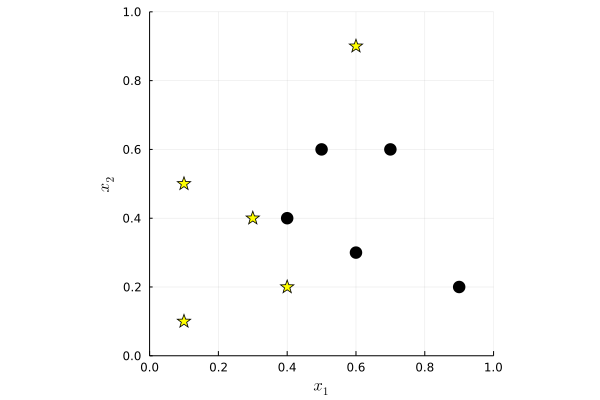

In [16]:
x = [0.1 0.3 0.1 0.6 0.4 0.6 0.5 0.9 0.4 0.7; 
     0.1 0.4 0.5 0.9 0.2 0.3 0.6 0.2 0.4 0.6] 
y = [ones(1,5) zeros(1,5)]
function plot_data(x,y)
     scatter!(x[1,1:5], x[2,1:5], m=:star, mc=:yellow, ms = 7, xlim=(0.0,1.0), ylim=(0.0,1.0))
     scatter!(x[1,6:10], x[2,6:10], m=:circle, ms = 7, mc=:black, 
        xlabel=L"x_1", ylabel=L"x_2", ratio=:equal)
end
plot(); plot_data(x,y)
# savefig("../tum/figures/data.pdf")

the step (aka 'Heaviside') function

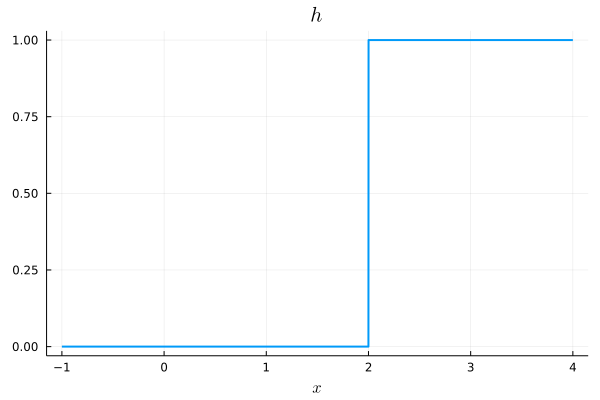

In [17]:
h(x) = x < 0 ? 0 : 1
plot(x -> h(x-2), -1, 4, lw=2, xlabel=L"x", title = L"h")
# savefig("../tum/figures/step2.pdf")

the better 'step' function: the sigmoid function

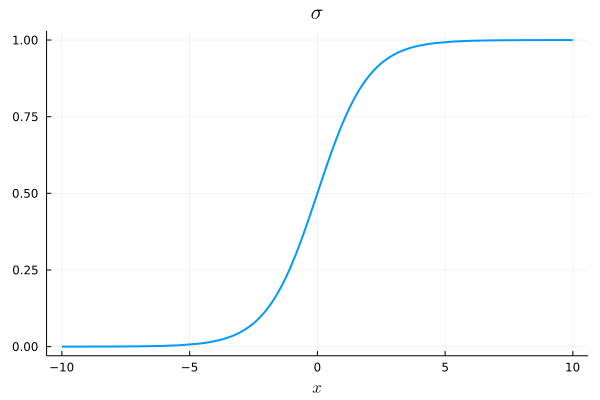

In [18]:
σ(x) = 1/(1+exp(-x))
plot(σ, -10, 10, lw=2, xlabel=L"x", title = L"\sigma")
# savefig("../tum/figures/sigmoid.pdf")

#### 1st attempt: classification by $x$-coordinate

In [19]:
C(b) = 1/10*norm(y - σ.(x[1:1,:] .+ b))^2
DC(b) = ForwardDiff.derivative(C,b)

DC (generic function with 1 method)

In [20]:
function gradient_descent(∇f, x, TOL)
    while norm(∇f(x)) > TOL
        x = x - ∇f(x)
    end
    return x
end

gradient_descent (generic function with 1 method)

-0.46185855686580696

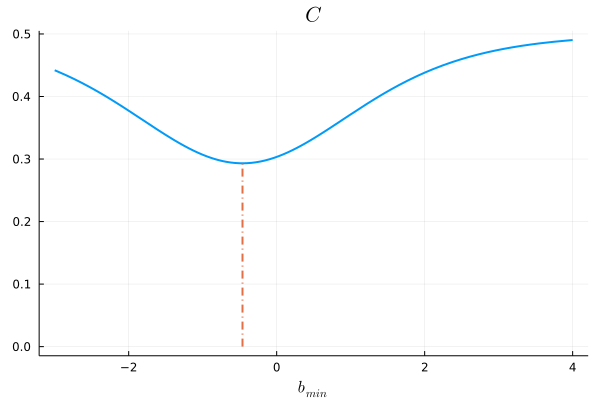

In [21]:
b_min = gradient_descent(DC, -0.5, 1e-6)
print(b_min)
plot(C, -3, 4, xlabel=L"b_{min}", lw=2, title=L"C", )
plot!([b_min, b_min], [0,C(b_min)], ls=:dashdot, lw=2)
# savefig("../tum/figures/cost1d.pdf")

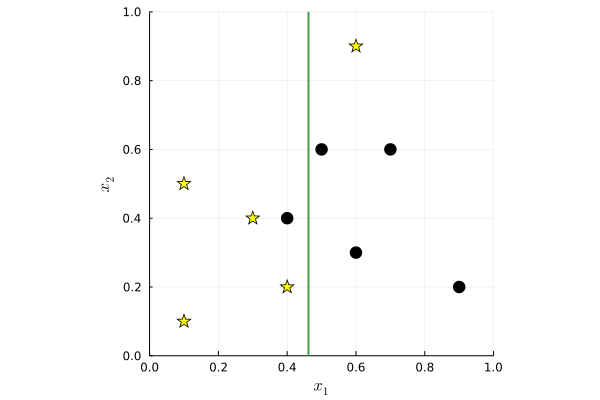

In [22]:
plot(); plot_data(x,y)
plot!([-b_min, -b_min], [0,1], lw=2)
# savefig("../tum../figures/data-result_1d.pdf")

#### 2nd attempt: classification by arbitrary line in the plane

In [23]:
F(w,b) = σ.(w'*x .+ b)
C(w,b) = 1/10*norm(y .- F(w,b))^2
C(p) = C(p[1:2], p[3])
DC(p) = ForwardDiff.gradient(C,p)
p = gradient_descent(DC, rand(3), 1e-2)

3-element Vector{Float64}:
 -4.1541494487016335
  0.9898469537572764
  1.4386264237178876

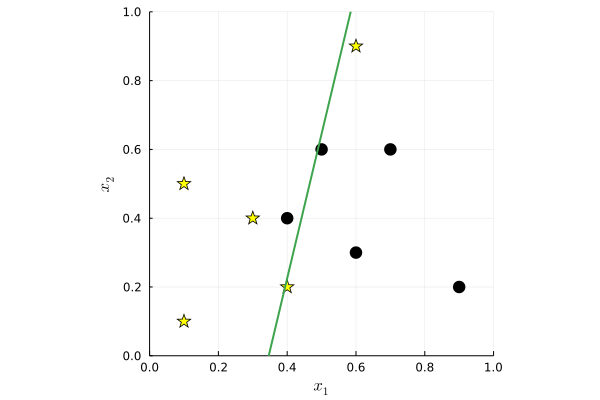

In [24]:
plot(); plot_data(x,y)
w = p[1:2]; b = p[3]
plot!([0, 1], [-b/w[2], -(b+w[1])/w[2]], lw=2)
# savefig(".../tum/figures/data-result_2d.pdf")

#### 3rd attempt: classification by two lines

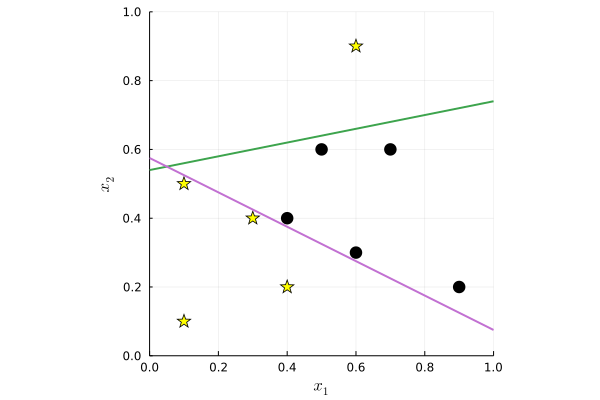

In [25]:
plot(); plot_data(x,y)
w = [-1, 5]; b = -2.7
plot!([0, 1], [-b/w[2], -(b+w[1])/w[2]], lw=2)
w = [-1, -2]; b = 1.15
plot!([0, 1], [-b/w[2], -(b+w[1])/w[2]], lw=2)
# savefig("../tum/figures/data-result_lines.pdf")

#### 4th attempt: network with four layers

In [26]:
y = [ones(1,5) zeros(1,5); zeros(1,5) ones(1,5)]

F(W2,W3,W4,b2,b3,b4,x) = σ.(W4*σ.(W3*σ.(W2*x .+ b2) .+ b3) .+ b4)
C(W2,W3,W4,b2,b3,b4) = 1/10*norm(y .- F(W2,W3,W4,b2,b3,b4,x))^2

C(p) = C(reshape(p[1:4],2,2), reshape(p[5:10],3,2), reshape(p[11:16],2,3), 
         p[17:18], p[19:21], p[22:23])
F(p,x) = F(reshape(p[1:4],2,2), reshape(p[5:10],3,2), reshape(p[11:16],2,3), 
         p[17:18], p[19:21], p[22:23],x)

F (generic function with 2 methods)

7.839191087491146e-13

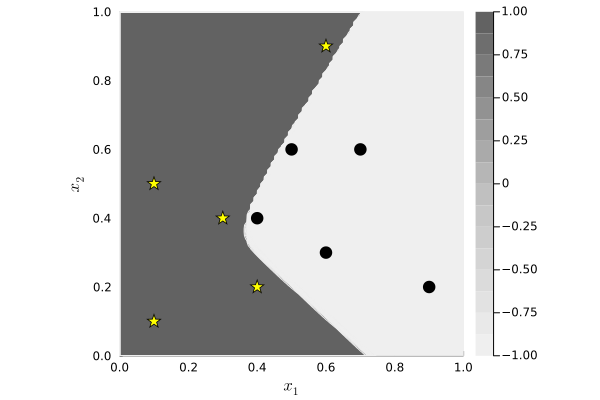

In [50]:
p0 = 20*rand(23).-10
result = optimize(C, p0, BFGS(), autodiff=:forward)
p_opt = Optim.minimizer(result)
print(C(p_opt))

H = (x,y) -> F(p_opt, [x,y])[1] - F(p_opt, [x,y])[2]
X = 0.0:0.01:1.0
Z = H.(X',X)
contourf(X,X,Z, colorbar=true, c=:Greys_3)
plot_data(x,y)
# savefig("data-result-deep.pdf")

#### activation functions

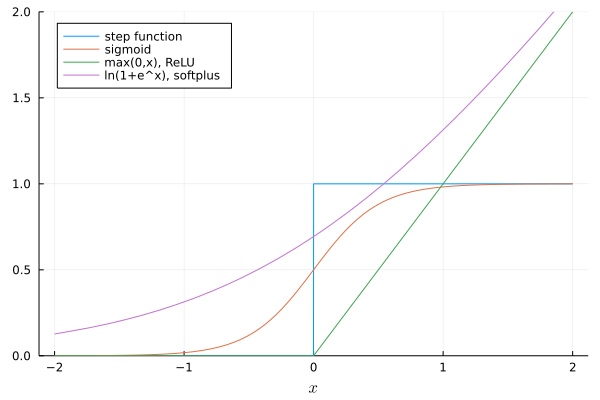

In [51]:
σ(x) = x < 0 ? 0 : 1
plot(σ, -2, 2, xlabel=L"x", legend=:topleft, label="step function", )
σ(x) = 1/(1+exp(-4x))
plot!(σ, -2, 2, label="sigmoid")
# σ(x) = tanh(x)
# plot!(σ, -2, 2, label="tanh(x)")
σ(x) = max(0.0,x)
plot!(σ, -2, 2, label="max(0,x), ReLU")
σ(x) = log(1+exp(x))
plot!(σ, -2, 2, ylim = (0,2), label="ln(1+e^x), softplus")

In [178]:
savefig("tum/figures/activation-1.pdf")